# Fraud Detection — Data Processing & Feature Assessment

This notebook covers the full pipeline between raw data and modeling:

1. **Setup** — libraries, MLflow, DVC, reproducibility
2. **Data Loading & DVC tracking**
3. **Feature Engineering** — derived from EDA findings
4. **Preprocessing Pipeline** — scaling, encoding, splits
5. **Class Imbalance Strategy** — class weights
6. **Feature Assessment** — Logistic Regression & Decision Tree with MLflow tracking
7. **Feature Selection** — rank and decide what goes into modeling

Every section documents the *hypothesis*, *action taken*, and *considerations* consistent with the EDA notebook.


# 1. Setup

## 1.1 Dependencies

**Notes**:
- `mlflow` for experiment tracking (local tracking server, `./mlruns`)
- `dvc` for data version control (local remote, `./dvc_store`)

In [80]:
# Standard
import os
import io
import json
import warnings
import subprocess
import time


from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# MLflow
import mlflow
import mlflow.sklearn

from utils.processing import sample_stratified_subset, evaluate_pipeline

print("All imports OK")


All imports OK


## 1.2 Reproducibility

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# paths
DATA_PATH   = "../data/raw/AIML_dataset.csv"   # DVC-tracked location
MLFLOW_URI  = "./mlruns"                     # local MLflow tracking
EXPERIMENT  = "fraud_feature_processing"

## 1.3 MLflow Configuration

**Notes**: For accessability, I will use a local tracking URI (`./mlruns`).


In [5]:
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(EXPERIMENT)

print(f"MLflow tracking URI : {mlflow.get_tracking_uri()}")
print(f"Experiment : {EXPERIMENT}")


MLflow tracking URI : ./mlruns
Experiment : fraud_feature_processing


# 2. Data Version Control (DVC)

**Action Taken**: At runtime we capture the DVC hash of the raw file and log
it as an MLflow tag on every run. This creates a hard link between any
experiment result and the exact data version used to produce it.


In [6]:
def get_dvc_hash(filepath):
    """Return the DVC md5 hash for a tracked file, or 'untracked'."""
    dvc_file = filepath + ".dvc"
    if not os.path.exists(dvc_file):
        return "untracked"
    with open(dvc_file) as f:
        for line in f:
            if "md5" in line:
                return line.strip().split()[-1]
    return "unknown"

DATA_VERSION = get_dvc_hash(DATA_PATH)
print(f"Data version (DVC md5): {DATA_VERSION}")

Data version (DVC md5): e92a5f7447f43712f1dca473d0b0fa85


# 3. Data Loading

In [7]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head(3)

Loaded: 6,362,620 rows × 11 columns


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


# 4. Feature Engineering

All features below are derived directly from insights in the EDA notebook.
Each transformation is documented with its rationale so the chain of reasoning
is explicit and auditable.

**Considerations**:
- Only non statistic information is applied to the full dataset *before* the train/test
  split so the derived columns exist for both sets.
- Statistics from the data will be computed after train/test split
  to avoid leakage risk.


## 4.1 Log-Transformed Amount

**Hypothesis**: `amount` spans 0 to ~92M with extreme right skew.
A log transform compresses the range and gives linear models a better chance
of finding a decision boundary. Tree models do not strictly need it, but
it makes visualisations more interpretable and keeps scales consistent.

**Action Taken**: `logAmount = log1p(amount)`.


In [8]:
df['logAmount'] = np.log1p(df['amount'])

## 4.2 Balance Error Features

**Hypothesis**: In a correct transaction,
`oldbalanceOrg - amount == newbalanceOrig` and
`oldbalanceDest + amount == newbalanceDest`.
Any deviation signals an inconsistency. The EDA showed these errors
are substantially more common in fraud cases, especially `errorBalanceDest`
where the destination balance is never updated.

**Action Taken**: Created two numeric error features, `errorBalanceOrig` and `errorBalanceDest`.


In [9]:
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

## 4.3 Destination Account Type

**Hypothesis**: The EDA confirmed that fraud only flows to customer accounts (prefix `C`),
never to merchant accounts (prefix `M`). Encoding this as a binary feature gives
models a direct, noise-free signal.

**Action Taken**: `destType` extracted from the first character of `nameDest`.
Encoded as binary integer (`C=1, M=0`) so it works for both linear and tree models
without needing a separate One Hot Encoding step.

**Consideration**: `origType` is constant (`C` for all rows), zero variance,
not created.


In [10]:
df['destTypeC'] = (df['nameDest'].str[0] == 'C').astype(int)

## 4.4 Cyclic Time Encoding

**Hypothesis**: My intuition is that `step` represents hours in a ~30-day period. Time series analysis show some seasonality (not statistically verified though). If there is a
daily cycle in fraud behaviour, raw step values do not capture the circular
nature of time (hour 0 and hour 23 are adjacent, not distant). Sine/cosine
encoding preserves this topology for linear models.

**Action Taken**: Encode hour-of-day (step % 24) with sin/cos.
The raw `step` is kept as well to preserve the longitudinal (day) signal.

**Consideration**: Tree models ignore the circular encoding issue, but including
it costs nothing and may help Logistic Regression.


In [11]:
hour = df['step'] % 24
df['hourSin'] = np.sin(2 * np.pi * hour / 24)
df['hourCos'] = np.cos(2 * np.pi * hour / 24)

## 4.5 Origin Account Drained Flag

**Hypothesis**: The EDA showed that a high proportion of fraud transactions
completely drain the origin account (`newbalanceOrig == 0` after a non-zero
starting balance). This is a good signal of potential fraudulent transaction.

**Action Taken**: Binary flag `isOrigDrained` as 1 if `newbalanceOrig == 0`
and `oldbalanceOrg > 0`, else 0.

In [12]:
df['isOrigDrained'] = (
    (df['newbalanceOrig'] == 0) & (df['oldbalanceOrg'] > 0)
).astype(int)

## 4.6 Feature Engineering Summary

In [13]:
engineered = [
    'logAmount', 'errorBalanceOrig', 'errorBalanceDest',
    'destTypeC', 'hourSin', 'hourCos', 'isOrigDrained'
]

print("New features:")
print(df[engineered].describe().T[['mean', 'min', 'max', 'count']])
print()
print("Nulls in engineered features:")
print(df[engineered].isnull().sum())


New features:
                           mean          min           max      count
logAmount             10.840874         0.00  1.834213e+01  6362620.0
errorBalanceOrig  201092.468053        -0.01  9.244552e+07  6362620.0
errorBalanceDest   55567.171867 -75885725.63  1.319123e+07  6362620.0
destTypeC              0.661854         0.00  1.000000e+00  6362620.0
hourSin               -0.449215        -1.00  1.000000e+00  6362620.0
hourCos               -0.303178        -1.00  1.000000e+00  6362620.0
isOrigDrained          0.238987         0.00  1.000000e+00  6362620.0

Nulls in engineered features:
logAmount           0
errorBalanceOrig    0
errorBalanceDest    0
destTypeC           0
hourSin             0
hourCos             0
isOrigDrained       0
dtype: int64


# 5. Feature Set Definition

**Hypothesis**: Based on EDA findings we define a deliberate feature set.
Explicitly listing included and excluded columns here makes the choices
reviewable and easy to modify.

## Excluded Columns & Rationale

| Column | Reason |
|---|---|
| `nameOrig` | High-cardinality ID, no generalizable signal |
| `nameDest` | Same; prefix captured in `destTypeC` |
| `isFlaggedFraud` | Rule-based system flag — leakage risk, captures only ~0.2% of fraud |
| `origType` | Zero variance (all `C`) |
| `amount` | Replaced by `logAmount` |
| `logAmount` (EDA col) | Duplicate of `logAmount` created here if EDA was run |


In [14]:
TARGET = 'isFraud'

# Categorical
CAT_FEATURES = ['type']

# Numeric — will be standard-scaled in the pipeline
NUM_FEATURES = [
    'step',
    'logAmount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'errorBalanceOrig',
    'errorBalanceDest',
    'hourSin',
    'hourCos',
]

# Binary — passed through as-is (already 0/1, no scaling needed)
BIN_FEATURES = ['destTypeC', 'isOrigDrained']

ALL_FEATURES = CAT_FEATURES + NUM_FEATURES + BIN_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  Categorical : {CAT_FEATURES}")
print(f"  Numeric     : {NUM_FEATURES}")
print(f"  Binary      : {BIN_FEATURES}")


Total features: 13
  Categorical : ['type']
  Numeric     : ['step', 'logAmount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'hourSin', 'hourCos']
  Binary      : ['destTypeC', 'isOrigDrained']


# 6. Train / Test Split

A stratified split is mandatory given the severe class
imbalance (~% fraud). Without stratification the test set could have
very few or zero fraud cases by chance.

**Action Taken**:
- 80/20 train/test split, stratified on `isFraud`
- `random_state` fixed for reproducibility
- The test set is set aside now and not touched until final model evaluation

**Consideration**: For this feature *assessment* phase we will use
cross-validation on the training set only. The test set is reserved for the
final modeling notebook to avoid any optimistic bias.


In [15]:
X = df[ALL_FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"Train : {X_train.shape[0]:>9,} rows  |  fraud: {y_train.sum():,} ({y_train.mean()*100:.3f}%)")
print(f"Test  : {X_test.shape[0]:>9,} rows  |  fraud: {y_test.sum():,} ({y_test.mean()*100:.3f}%)")


Train : 4,453,834 rows  |  fraud: 5,749 (0.129%)
Test  : 1,908,786 rows  |  fraud: 2,464 (0.129%)


# 7. Preprocessing Pipeline

Wrapping all preprocessing in a `sklearn Pipeline` + `ColumnTransformer`
guarantees that:
1. Scaling statistics (mean, std) are learned *only* on training data
2. The exact same transformations are applied to test data automatically
3. The pipeline object can be serialized by MLflow as a single artifact

**Action Taken**: One shared `preprocessor` object is defined here and reused
across all model experiments to ensure identical preprocessing for every run.

**Note on binary features**: `destTypeC` and `isOrigDrained` are already 0/1
integers. They are passed through with `remainder='passthrough'` rather than
scaled, to preserve their interpretability.


In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_FEATURES),
    ],
    remainder='passthrough'
)

# 8. Class Imbalance Strategy

With ~0.001% fraud rate, an untrained model predicting
"never fraud" achieves >99% accuracy which is meaningless result. We need to
penalise misclassifying the minority class more heavily.

**Strategy chosen: `class_weight='balanced'`**

This instructs sklearn to weight each class inversely proportional to its
frequency in the training set:
`weight = n_samples / (n_classes × n_samples_per_class)`

**Why not SMOTE or undersampling at this stage?**
- Resampling modifies the training distribution and can interact with cross-validation
  in subtle ways.
- For feature *assessment*, class weights are sufficient to surface which features
  carry signal. Nothing prevent to revisit resampling in the future modeling.

**Metrics we will use**:
- **Precision / Recall / F1** on the fraud class
- **ROC-AUC** → overall discrimination
- **Average Precision (AUC-PR)** → most informative for imbalanced datasets


In [17]:
CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# 9. Experiment 1 — Logistic Regression (Baseline)

**Hypothesis**: Logistic Regression is chosen as baseline because:
- Its coefficients directly indicate the *direction* and *magnitude* of each
  feature's linear contribution to the log-odds of fraud.
- If LR achieves reasonable recall, the feature set already has strong linear signal.
- If recall is poor, it suggests the decision boundary is non-linear. This is expected
  given the balance error features, which have heavy tails.

**Setup**:
- `class_weight='balanced'` to handle imbalance
- `max_iter=1000` to ensure convergence on scaled data
- `solver='saga'` efficient for large datasets with L1/L2 regularisation

**Consideration**: LR assumes linear separability after feature transforms.
Our log/error features partially address this but a tree model will likely
outperform it.


In [18]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        max_iter=200,
        tol=1e-3,
        solver='saga',
        C=0.1,
        random_state=RANDOM_SEED
    ))
])

In [20]:
with mlflow.start_run(run_name="logistic_regression_baseline"):

    # log config
    mlflow.set_tag("data_version", DATA_VERSION)
    mlflow.set_tag("model_type", "LogisticRegression")
    mlflow.set_tag("imbalance_strategy", "class_weight_balanced")
    mlflow.log_param("random_seed", RANDOM_SEED)
    mlflow.log_param("C", 0.1)
    mlflow.log_param("solver", "saga")
    mlflow.log_param("features", json.dumps(ALL_FEATURES))

    start_time = time.perf_counter()

    # cross-validate
    lr_scores = evaluate_pipeline(lr_pipeline, X_train, y_train,
                                  label="Logistic Regression", use_subset=True)

    training_time = time.perf_counter() - start_time
    mlflow.log_metric("training_time_seconds", training_time)

    # log metrics
    for k, v in lr_scores.items():
        mlflow.log_metric(k, v)

    lr_run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow run id: {lr_run_id}")

Sampling 500000 rows for fast evaluation...

── Logistic Regression ──
  roc_auc     : 0.9928
  avg_prec    : 0.7044
  f1_fraud    : 0.0570
  precision   : 0.0294
  recall      : 0.9891

MLflow run id: 230ef36bfe6e48e6ab12d2676d62e132


## 9.1 Logistic Regression — Coefficient Analysis

**Hypothesis**: Features with large absolute coefficients (after standardisation)
have the strongest linear association with fraud. This gives us a first ranking
of feature importance.

**Observations**:
- `oldbalanceOrg`, `newbalanceOrig`, `newbalanceDest`, `oldbalanceDest` dominate
- `errorBalanceDest` and `errorBalanceOrig` have high values but are not the most informative features.
- Some transaction type have strong coefficients.
- `isOrigDrained` and `errorBalanceDest` are smaller but non-zero. This is reasonable for secondary signals.


In [24]:
X_train_subset, y_train_subset = sample_stratified_subset(X_train, y_train, n=500_000, random_seed=RANDOM_SEED)

with mlflow.start_run(run_name="logistic_regression_reference"):

    mlflow.set_tag("data_version", DATA_VERSION)
    mlflow.set_tag("model_type", "LogisticRegression")
    mlflow.set_tag("purpose", "interpretability")

    mlflow.log_param("random_seed", RANDOM_SEED)
    mlflow.log_param("C", 0.1)
    mlflow.log_param("solver", "saga")
    mlflow.log_param("features", json.dumps(ALL_FEATURES))

    start_time = time.perf_counter()

    lr_pipeline.fit(X_train_subset, y_train_subset)

    training_time = time.perf_counter() - start_time

    mlflow.sklearn.log_model(lr_pipeline, artifact_path="model")

    mlflow.log_metric("training_time_seconds", training_time)

2026/02/21 16:49:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 16:49:10 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


In [29]:
feature_names = (
    lr_pipeline
    .named_steps["preprocessor"]
    .get_feature_names_out()
)

coefs = lr_pipeline.named_steps["clf"].coef_[0]

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .assign(abs_coef=lambda df: df.coef.abs())
    .sort_values("abs_coef", ascending=False)
)

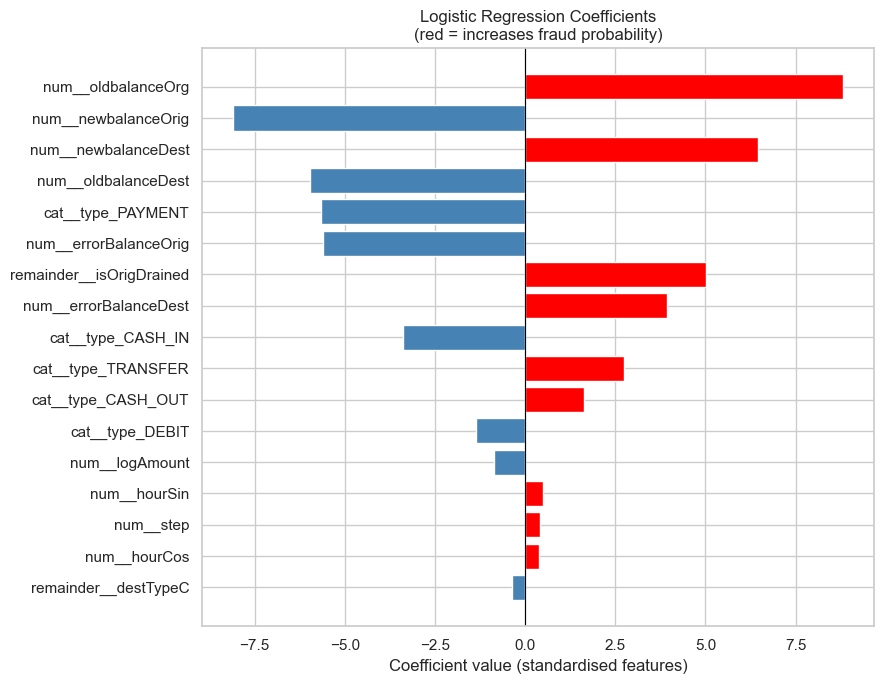

In [35]:
plt.figure(figsize=(9, 7))
top = coef_df
colors = ['red' if c > 0 else 'steelblue' for c in top['coef']]
plt.barh(top['feature'][::-1], top['coef'][::-1], color=colors[::-1])
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Coefficients\n(red = increases fraud probability)')
plt.xlabel('Coefficient value (standardised features)')
plt.tight_layout()
plt.show()

## 10.1 RandomForest — Feature Importances

**Observations**:
- The Random Forest outperforms Logistic Regression, suggesting that the feature space contains meaningful non-linear relationships.
- The most influential features in the Random Forest are `errorBalanceOrig`, `isOrigDrained`, `oldbalanceOrg`, `newbalanceOrig`, and `logAmount`.
- While the ranking of feature importance differs between models, the same key features appear among the top predictors in both.


In [62]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=RANDOM_SEED,
        min_samples_leaf=50,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

In [64]:
X_train_subset, y_train_subset = sample_stratified_subset(X_train, y_train, n=500_000, random_seed=RANDOM_SEED)

# --- Random Forest Reference Fit ---
with mlflow.start_run(run_name="random_forest_depth10"):

    mlflow.set_tag("data_version", DATA_VERSION)
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("imbalance_strategy", "class_weight_balanced")
    mlflow.set_tag("purpose", "interpretability")
    mlflow.log_param("random_seed", RANDOM_SEED)
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_leaf", 50)
    mlflow.log_param("features", json.dumps(ALL_FEATURES))

    start_time = time.perf_counter()
    rf_pipeline.fit(X_train_subset, y_train_subset)
    training_time = time.perf_counter() - start_time

    mlflow.sklearn.log_model(rf_pipeline, artifact_path="model")

    # Evaluation: threshold-free metrics
    y_pred_proba = rf_pipeline.predict_proba(X_train_subset)[:, 1]
    roc_auc = roc_auc_score(y_train_subset, y_pred_proba)
    avg_prec = average_precision_score(y_train_subset, y_pred_proba)

    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("average_precision", avg_prec)
    mlflow.log_metric("training_time_seconds", training_time)

    # Feature importances
    rf_model = rf_pipeline.named_steps["model"]
    feature_names = rf_pipeline.named_steps["preprocessor"].get_feature_names_out()
    importances = rf_pipeline.named_steps["model"].feature_importances_

    rf_feat_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)
    mlflow.log_text(rf_feat_df.head(20).to_csv(index=False), "top_rf_features.csv")

    rf_run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow run id: {rf_run_id}")

2026/02/21 17:27:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 17:27:29 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html



MLflow run id: 650994d57fc547f3a7fc5eb804edadce


In [69]:
# Predict probabilities from your fitted logistic regression
y_lr_pred_proba = lr_pipeline.predict_proba(X_train_subset)[:, 1]
y_rf_pred_proba = rf_pipeline.predict_proba(X_train_subset)[:, 1]

threshold = 0.5

# Logistic Regression
y_lr_pred = (y_lr_pred_proba >= threshold).astype(int)
precision_lr = precision_score(y_train_subset, y_lr_pred)
recall_lr = recall_score(y_train_subset, y_lr_pred)
f1_lr = f1_score(y_train_subset, y_lr_pred)

# Random Forest
y_rf_pred = (y_rf_pred_proba >= threshold).astype(int)
precision_rf = precision_score(y_train_subset, y_rf_pred)
recall_rf = recall_score(y_train_subset, y_rf_pred)
f1_rf = f1_score(y_train_subset, y_rf_pred)

comparison_thresholded = pd.DataFrame({
    "model": ["Logistic Regression", "Random Forest"],
    "precision": [precision_lr, precision_rf],
    "recall": [recall_lr, recall_rf],
    "f1": [f1_lr, f1_rf]
})

print(comparison_thresholded)

                 model  precision    recall       f1
0  Logistic Regression   0.026982  0.987597  0.05253
1        Random Forest   1.000000  1.000000  1.00000


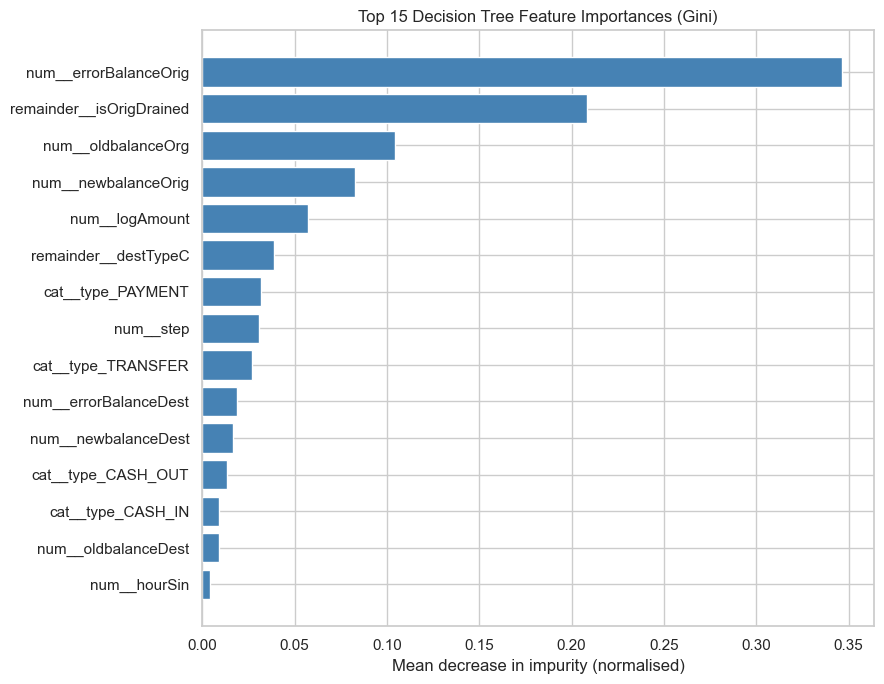

In [66]:
plt.figure(figsize=(9, 7))
top_imp = rf_feat_df.head(15)
plt.barh(top_imp['feature'][::-1], top_imp['importance'][::-1], color='steelblue')
plt.title('Top 15 Decision Tree Feature Importances (Gini)')
plt.xlabel('Mean decrease in impurity (normalised)')
plt.tight_layout()
plt.show()

# 12. Feature Selection & Ranking

**Hypothesis**: Features that rank consistently high across *both* models
(LR absolute coefficient + DT Gini importance) are the most reliable signals. Features that rank low in both are candidates for removal.

**Action Taken**:
- Normalise each ranking to [0, 1]
- Compute a consensus score = mean of the two normalised ranks
- Flag features with consensus score < 0.05 as low-value candidates for removal

**Consideration**: The final decision on dropping features should also consider
domain logic (e.g. `step` may have low statistical importance but is needed
for temporal integrity checks).


In [71]:
# normalise each importance to [0,1]
coef_norm = coef_df.set_index('feature')['coef'].abs()
coef_norm = (coef_norm - coef_norm.min()) / (coef_norm.max() - coef_norm.min())

imp_norm = rf_feat_df.set_index('feature')['importance']
imp_norm = (imp_norm - imp_norm.min()) / (imp_norm.max() - imp_norm.min())

ranking = pd.DataFrame({
    'LR_coef_norm'   : coef_norm,
    'DT_imp_norm'    : imp_norm,
}).fillna(0)

ranking['consensus'] = ranking.mean(axis=1)
ranking = ranking.sort_values('consensus', ascending=False)

print(ranking.round(3).to_string())


                          LR_coef_norm  DT_imp_norm  consensus
feature                                                       
num__errorBalanceOrig            0.620        1.000      0.810
num__oldbalanceOrg               1.000        0.301      0.650
num__newbalanceOrig              0.914        0.238      0.576
remainder__isOrigDrained         0.550        0.601      0.576
num__newbalanceDest              0.719        0.047      0.383
cat__type_PAYMENT                0.624        0.091      0.358
num__oldbalanceDest              0.661        0.025      0.343
num__errorBalanceDest            0.420        0.053      0.237
cat__type_CASH_IN                0.358        0.025      0.192
cat__type_TRANSFER               0.281        0.077      0.179
num__logAmount                   0.059        0.165      0.112
cat__type_CASH_OUT               0.150        0.038      0.094
cat__type_DEBIT                  0.117        0.000      0.059
remainder__destTypeC             0.000        0.112    

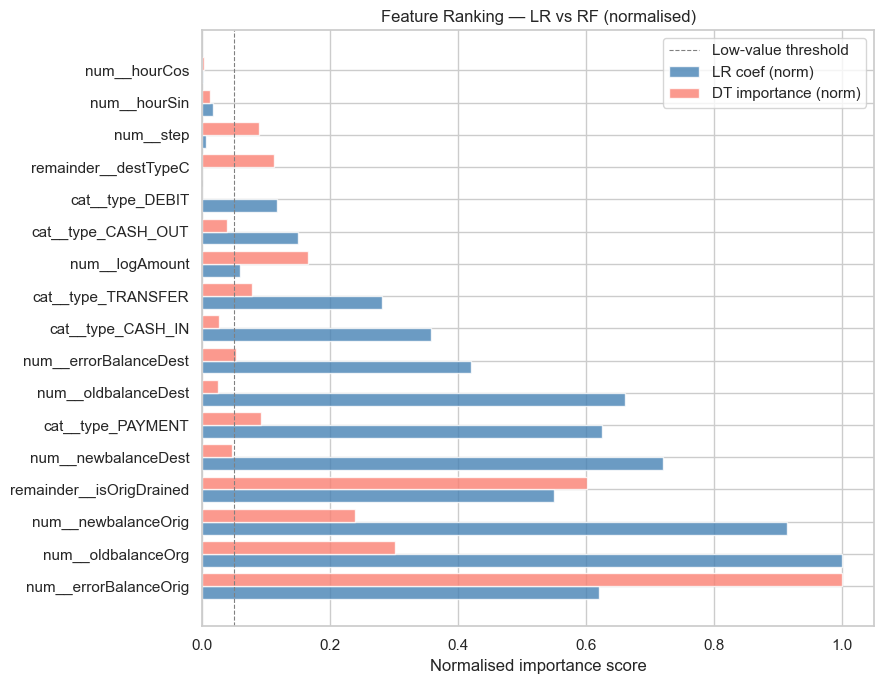

In [73]:
plt.figure(figsize=(9, 7))
y_pos = np.arange(len(ranking))

plt.barh(y_pos, ranking['LR_coef_norm'],  0.4, label='LR coef (norm)', color='steelblue', alpha=0.8)
plt.barh(y_pos + 0.4, ranking['DT_imp_norm'], 0.4, label='DT importance (norm)', color='salmon', alpha=0.8)

plt.yticks(y_pos + 0.2, ranking.index)
plt.axvline(0.05, color='grey', linestyle='--', linewidth=0.8, label='Low-value threshold')
plt.title('Feature Ranking — LR vs RF (normalised)')
plt.xlabel('Normalised importance score')
plt.legend()
plt.tight_layout()
plt.show()


## 12.1 Candidate Feature Drop List

**Action Taken**: Features with consensus score < 0.05 are listed below.

**Observations**:
- `hourSin` / `hourCos` has low score.
- `step` as raw numeric value despite being relevant for RF has very low consensus score.

**Consideration**: For this project, `hourSin` / `hourCos` and `step` will be dropped. However, keeping them is still an option if we want to include temporal patterns into modeling.


In [74]:
THRESHOLD = 0.05
low_value = ranking[ranking['consensus'] < THRESHOLD]

if low_value.empty:
    print("No features below the threshold — all features contribute meaningfully.")
else:
    print(f"Features with consensus score < {THRESHOLD}:")
    print(low_value[['LR_coef_norm', 'DT_imp_norm', 'consensus']].round(4).to_string())


Features with consensus score < 0.05:
              LR_coef_norm  DT_imp_norm  consensus
feature                                           
num__step           0.0050       0.0881     0.0466
num__hourSin        0.0161       0.0118     0.0139
num__hourCos        0.0014       0.0027     0.0021


# 13. Final Feature Set & Processed Data Export

**Action Taken**: Assemble the final processed dataset containing only
the approved features and export it as a CSV.

The exported file is then tracked with DVC so the modeling notebook always
picks up a versioned, reproducible artifact.


In [75]:
FEATURES_TO_DROP = ['hourSin', 'hourCos', 'step']

FINAL_FEATURES = [f for f in ALL_FEATURES if f not in FEATURES_TO_DROP]

# Build final processed dataframe
df_processed = df[FINAL_FEATURES + [TARGET]].copy()

print(f"Final feature count : {len(FINAL_FEATURES)}")
print(f"Final dataset shape : {df_processed.shape}")
print(f"Fraud rate          : {df_processed[TARGET].mean()*100:.4f}%")


Final feature count : 10
Final dataset shape : (6362620, 11)
Fraud rate          : 0.1291%


In [77]:
os.makedirs("../data/processed", exist_ok=True)

# CSV export
OUT_PATH_CSV = "../data/processed/fraud_processed.csv"
df_processed.to_csv(OUT_PATH_CSV, index=False)
print(f"Saved processed dataset → {OUT_PATH_CSV}")

Saved processed dataset → ../data/processed/fraud_processed.csv


# 14. Random Forest - Learning Curve

**Hypothesis**: Training on full dataset (~4M+ rows) is resource intensive. During processing and pre-modeling, I used a subset of 500,000 rows. It is clever to identify is more data improves classification performance to save time.

**Observation**:
- Average Precision learning curve shows a validation plateau over 1,000,000 rows

**Consideration**: Learning the model using the whole training set may not be necessary. A subsample of 1 million rows should be enough to reach satisfying performance.

In [82]:
with mlflow.start_run(run_name="random_forest_depth10"):

    # --- Log configuration ---
    mlflow.set_tag("data_version", DATA_VERSION)
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("imbalance_strategy", "class_weight_balanced")
    mlflow.set_tag("purpose", "interpretability")
    mlflow.log_param("random_seed", RANDOM_SEED)
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_leaf", 50)
    mlflow.log_param("features", json.dumps(ALL_FEATURES))

    # --- Learning curve ---
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=rf_pipeline,
        X=X_train_subset,
        y=y_train_subset,
        train_sizes=np.linspace(0.1, 1.0, 15),
        cv=3,
        scoring='average_precision',
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_SEED
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    valid_mean = valid_scores.mean(axis=1)
    valid_std = valid_scores.std(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Average Precision')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation Average Precision')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='green')
    plt.title('Random Forest Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Average Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save figue
    plot_path = "learning_curve.png"
    plt.savefig(plot_path)
    plt.close()

    # Log to MLflow
    mlflow.log_artifact(plot_path, artifact_path="plots")

    rf_run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow run id: {rf_run_id}")


MLflow run id: 77d56d6f81434e7e82b044efd1875e75


# 15. Processing Stage Summary

## Feature Engineering Decisions

| Feature | Rationale                                                   | Status     |
|---|-------------------------------------------------------------|------------|
| `logAmount` | Compresses right-skewed amount                              | ✅ Kept     |
| `errorBalanceOrig` | Balance inconsistency at origin - EDA fraud signal          | ✅ Kept     |
| `errorBalanceDest` | Balance inconsistency at destination - strongest EDA signal | ✅ Kept     |
| `destTypeC` | Fraud exclusively targets C accounts                        | ✅ Kept     |
| `isOrigDrained` | Exact account drain is a sharp fraud pattern                | ✅ Kept     |
| `hourSin` / `hourCos` | Cyclic time encoding — review ranking output                | ⚠️ Dropped |
| `step` | Raw longitudinal signal                                     | ⚠️ Dropped |

## Preprocessing Decisions

| Choice          | Decision                                | Rationale                         |
|-----------------|-----------------------------------------|-----------------------------------|
| Scaling         | `StandardScaler` on numeric features    | Required for LR convergence       |
| Encoding        | `OneHotEncoder` on `type`               | 5 categories, low cardinality     |
| Split           | 70/30 stratified                        | Maintains fraud rate in both sets |
| CV              | `StratifiedKFold(n=3)`                  | Robust estimate under imbalance   |
| Imbalance       | `class_weight='balanced'`               | Simplest, no data leakage risk    |
| Subset strategy | Trained on 500,000 samples (stratified) | Fastest for training and analysis |

## Next Steps — Modeling Notebook

- Train: Random Forest, XGBoost
- Hyperparameter tuning with MLflow experiment tracking
- Threshold optimization (precision/recall tradeoff)
- Final evaluation on held-out test set
